# MS003 Epoching
10/05/2023

In [30]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import emd
import re
import scipy
import h5io


import warnings
warnings.filterwarnings('ignore')

In [5]:
import sys
# sys.path.append('/Users/alexandrafink/Documents/GitHub/LFPAnalysis')
sys.path.append('/Users/alexandrafink/Documents/GitHub/afink_lfp_pipeline/LFPAnalysis')

In [6]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

In [35]:
subj_id = 'MS003'


base_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/'
anat_dir = f'{base_dir}anat_recons/recon_labels/{subj_id}'
neural_dir = f'{base_dir}ephys_analysis/data/{subj_id}'
behav_dir = f'{base_dir}behavior_analysis/behavior_preprocessed/'
tfr_dir = f'{base_dir}ephys_analysis/figs/TFRs/{subj_id}/all_trials/'
os.makedirs(tfr_dir,exist_ok = True) #added so you don't have to manually make subject folders in clean_data


# Import Preprocessed Data (WM), Photodiode Data, Behavior Data, and Anatomical Reconstruction

In [8]:
#rereferenced neural data
#mne_data_reref = mne.io.read_raw_fif(f'{neural_dir}/wm_ref_ieeg.fif', preload=True)
#mne_data_reref = mne.io.read_raw_fif(f'{neural_dir}/bp_ref_ieeg.fif', preload=True)
#photodiode data
photodiode_data = mne.io.read_raw_fif(f'{neural_dir}/photodiode.fif', preload=True)
#behavior data 
behav_df = pd.read_csv(f'{behav_dir}{subj_id}_task_data')
behav_df = behav_df[behav_df.columns.drop(list(behav_df.filter(regex='Unnamed')))]
behav_df = behav_df[behav_df['FeedbackOnset'] != 0] #remove fail trials from behav df
beh_ts = behav_df['TrialOnset'] #timestamp that should be aligned to photodiode 
#anat recon file
anat_file = glob(f'{anat_dir}_labels.csv')[0]
elec_locs = pd.read_csv(anat_file)

# Photodiode Alignment

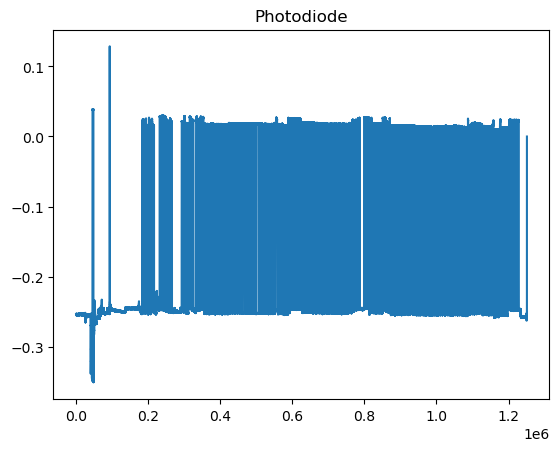

In [11]:
# Sanity check the photodiode
plt.plot(photodiode_data._data[0,])
plt.title("Photodiode")
plt.show()

In [13]:
### Photodiode alignment

# Synchronize to the photodiode or whatever your neural sync signal is
slope, offset = sync_utils.synchronize_data(beh_ts, 
                                            photodiode_data, 
                                            smoothSize=11, windSize=15, height=0.7)

11 blocks
...........

found matches for 75 of 170 pulses


In [14]:
print(slope,offset)

0.999991952320566 -6.51233213197122


# Epoch Data
Make sure bad trials are removed from DF before epoching
IED args should be tested 


In [15]:
# IED removal requires that we set some parameters for IED detection. 
# 1. peak_thresh: how many stds should they exceed the baseline by? 
# 2. closeness_thresh: how close should they be allowed to be (in sec) to other candidate IEDs? 
# 3. width_thresh: how wide should they have to be (in sec)?

# Defaults:
IED_args = {'peak_thresh':4,
           'closeness_thresh':0.25, 
           'width_thresh':0.2}


In [16]:
# Create a dictionary with your event name (matching your dataframe), and the time-window for the event
evs = {'TrialOnset': [-1.0, 0], #ITI is always at least one second + 10ms buffer for wavelet padding (no horizontal smearing)
       'DecisionOnset': [0, 5.0]} #1 sec decision period + 2 second outcome + 3 second counterfactual

In [17]:
epochs_all_evs = {f'{x}': np.nan for x in evs}

In [19]:
for event in evs.keys():
    # Make the epochs. 
    ev_epochs = lfp_preprocess_utils.make_epochs(load_path=f'{neural_dir}/wm_ref_ieeg.fif', 
    #ev_epochs = lfp_preprocess_utils.make_epochs(load_path=f'{neural_dir}{subj_id}/bp_ref_ieeg.fif', 
                 slope=slope, offset=offset,
                 behav_name=event, behav_times=behav_df[event].values, 
                 ev_start_s=evs[event][0], ev_end_s=evs[event][1], buf_s = 1.0, IED_args=IED_args) #1.0 buf unsaved

    epochs_all_evs[event] = ev_epochs

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 583 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 16938 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 17493 out of 17493 | elapsed:    3.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 119 out of 119 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 2040 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 17130 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 17493 out of 17493 | elapsed:    3.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 task

In [20]:
epochs_all_evs

{'TrialOnset': <Epochs |  147 events (all good), -2 - 1 sec, baseline off, ~200.5 MB, data loaded, with metadata,
  'TrialOnset': 147>,
 'DecisionOnset': <Epochs |  147 events (all good), -1 - 6 sec, baseline off, ~467.4 MB, data loaded, with metadata,
  'DecisionOnset': 147>}

# Add behavioral metadata to epochs

In [21]:
behav_params = ['SafeBet', 'LowBet', 'HighBet','GambleChoice', 'Outcome',
                'Profit', 'TotalProfit', 'GambleEV', 'CR', 'choiceEV', 'RPE',
                'totalCPE', 'decisionCPE', 'totalRegret', 'decisionRegret',
                'totalRelief', 'decisionRelief', 'totalCF', 'decisionCF', 'pRPE','nRPE']

In [22]:
for event in evs.keys():

    event_metadata = epochs_all_evs[event].metadata.copy()
    
    #independent vars
    for param in behav_params: 
        event_metadata[param] = behav_df[param].tolist()

    epochs_all_evs[event].metadata = event_metadata 
    

In [23]:
epochs_all_evs[event].metadata

,lmolf9,rmolf8,rmolf9,lacas8,lacas12,racas6,racas9,racas12,lmcms5,lmcms6,...,totalCPE,decisionCPE,totalRegret,decisionRegret,totalRelief,decisionRelief,totalCF,decisionCF,pRPE,nRPE
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.90,-0.60,-1.90,-0.60,0.00,0.00,1.90,0.60,0.000,-0.95
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.39,0.09,0.00,0.00,0.39,0.09,-0.30,0.00,0.195,0.00
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.41,0.41,0.00,0.00,0.41,0.41,-1.01,-1.01,0.000,0.00
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.50,0.50,0.00,0.00,0.50,0.50,0.00,0.00,0.000,0.00
4,[2689],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.32,-1.10,-1.32,-1.10,0.00,0.00,0.22,0.00,0.000,-0.66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.30,-1.30,-1.30,-1.30,0.00,0.00,1.80,1.80,0.000,0.00
143,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-2.20,-1.10,-2.20,-1.10,0.00,0.00,1.10,0.00,0.000,-1.10
144,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.41,-0.41,-0.41,-0.41,0.00,0.00,0.91,0.91,0.000,0.00
145,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.46,0.16,0.00,0.00,0.46,0.16,-0.30,0.00,0.230,0.00


## Save raw epoched data

In [24]:
#might not be necessary to save here
for event in evs.keys():
    epochs_all_evs[event].save(f'{neural_dir}/wm_epoch_{event}.fif', overwrite=True)
    #epochs_all_evs[event].save(f'{neural_dir}{subj_id}/bp_epoch_{event}.fif', overwrite=True)

# Baselining

In [26]:
# Set some spectrogram parameters 
freqs = np.logspace(*np.log10([2, 200]), num=30)
n_cycles = 3
sr = 500.0 
buf = 1.0
buf_ix = int(buf*sr)
# freqs

In [27]:
# Explicitly define a list of analysis events and the baseline event. Should correspond to the dict
analysis_evs = ['DecisionOnset']
baseline_ev = 'TrialOnset'
evs = {'TrialOnset': [-1.0, 0], #maybe increase to full second to take cycles up to 4
       #ITI is always at least one second + 10ms buffer for wavelet padding (no horizontal smearing)
       'DecisionOnset': [0, 5.0]} #1 sec decision period + 2 second outcome + 3 second counterfactual

In [28]:
epochs_all_baseline = {} #removed unecessary 'decisiononset' empty key

In [29]:
#baseline epoch - 
event = 'TrialOnset'
epochs = epochs_all_evs[event]

good_chans = [x for x in epochs.ch_names if x not in epochs.info['bads']]
picks = [x for x in good_chans]

pow_struct = np.nan * np.ones([epochs._data.shape[0], 
                       epochs._data.shape[1], len(freqs), 
                       epochs._data.shape[-1]])

for ch_ix in np.arange(epochs._data.shape[1]): 
    ch_data = epochs._data[:, ch_ix:ch_ix+1, :]
    bad_epochs  = np.where(epochs.metadata[epochs.ch_names[ch_ix]].notnull())[0]
    good_epochs = np.delete(np.arange(ch_data.shape[0]), bad_epochs)
    ch_data = np.delete(ch_data, bad_epochs, axis=0)
    ch_pow = mne.time_frequency.tfr_array_morlet(ch_data, sfreq=epochs.info['sfreq'], 
                                        freqs=freqs, n_cycles=n_cycles, zero_mean=False, 
                                        use_fft=True, output='power', n_jobs=1)

    pow_struct[good_epochs, ch_ix, :, :] = ch_pow[:, 0, :, :]

temp_pow = mne.time_frequency.EpochsTFR(epochs.info, pow_struct, 
                                        epochs.times, freqs)
temp_pow.crop(tmin=evs[event][0], tmax=evs[event][1])

epochs_all_baseline[event] = temp_pow

In [31]:
epochs_all_baseline

{'TrialOnset': <EpochsTFR | time : [-1.000000, 0.000000], freq : [2.000000, 200.000000], epochs : 147, channels : 119, ~1.96 GB>}

In [32]:
power_epochs = {}

In [33]:
event = 'DecisionOnset'

epochs = epochs_all_evs[event]

# Let's make sure we only do this for good channels
good_chans = [x for x in epochs.ch_names if x not in epochs.info['bads']]
picks = [x for x in good_chans]

pow_struct = np.nan * np.ones([epochs._data.shape[0], 
                       epochs._data.shape[1], len(freqs), 
                       epochs._data.shape[-1]])

for ch_ix in np.arange(epochs._data.shape[1]): 
    ch_data = epochs._data[:, ch_ix:ch_ix+1, :]
    bad_epochs  = np.where(epochs.metadata[epochs.ch_names[ch_ix]].notnull())[0] 
    good_epochs = np.delete(np.arange(ch_data.shape[0]), bad_epochs)
    ch_data = np.delete(ch_data, bad_epochs, axis=0) #this is where bad epochs for ch are deleted!!
    ch_pow = mne.time_frequency.tfr_array_morlet(ch_data, sfreq=epochs.info['sfreq'], 
                                        freqs=freqs, n_cycles=n_cycles, zero_mean=False, 
                                        use_fft=True, output='power', n_jobs=1)

    pow_struct[good_epochs, ch_ix, :, :] = ch_pow[:, 0, :, :]

temp_pow = mne.time_frequency.EpochsTFR(epochs.info, pow_struct, 
                                        epochs.times, freqs)

temp_pow.crop(tmin=evs[event][0], tmax=evs[event][1])


baseline_corrected_power = lfp_preprocess_utils.baseline_trialwise_TFR(data=temp_pow.data, 
                                                  baseline_mne=epochs_all_baseline['TrialOnset'], 
                                                  mode='zscore', 
                                                  trialwise=False, #discussed change with salman bc of small baseline time
                                                  baseline_only=True) ### test trialwise true 


zpow = mne.time_frequency.EpochsTFR(epochs.info, baseline_corrected_power, 
                                temp_pow.times, freqs)

zpow.metadata = epochs_all_evs[event].metadata

power_epochs[event] = zpow



In [36]:
power_epochs['DecisionOnset']

<EpochsTFR | time : [0.000000, 5.000000], freq : [2.000000, 200.000000], epochs : 147, channels : 119, ~9.78 GB>

In [37]:
#conda install -c conda-forge h5io must install to save tfr data
#power_epochs['DecisionOnset'].save(f'{neural_dir}{subj_id}/bp_pow_epochs-tfr.h5', overwrite=True)
power_epochs['DecisionOnset'].save(f'{neural_dir}/wm_pow_epochs-tfr.h5', overwrite=True)


# Wavelet TFRs

## All Trials Every Elec TFRs

In [38]:
event = 'DecisionOnset'
yticks = [4, 12, 30, 60, 90, 120, 150, 180, 200]
good_ch = [x for x in power_epochs[event].ch_names if '-' in x]
save_path = tfr_dir


for ch in good_ch:
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    times = power_epochs[event].times
    plot_data = np.nanmean(np.nanmean(power_epochs[event].copy().pick_channels([ch]).data, axis=0), axis=0)

    im = ax.imshow(plot_data,
            extent=[times[0], times[-1], freqs[0], freqs[-1]], interpolation='Bicubic',
            aspect='auto', origin='lower', cmap='RdBu_r',vmin = -np.nanmax(np.abs(plot_data)), vmax = np.nanmax(np.abs(plot_data)))
    ax.set(yticks=yticks, xlabel='Time (s)', ylabel='Frequency',title=f'{ch} Encoding')
    ax.yaxis.set_tick_params(labelsize=8)
    fig.colorbar(im, ax=ax)
    plt.savefig(f'{save_path}/{ch}_wmref_baselineonly.png', format='png', metadata=None,
    #plt.savefig(f'{save_path}bp_ref_baselineonly/{ch}.png', format='png', metadata=None,
    bbox_inches=None, pad_inches=0.1,
    facecolor='auto', edgecolor='auto',
    backend=None)
    plt.close()
